In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Classification project for Megaline

## The aim of this project is to create a ML algorithm to predict a plan customers would choose, for Mobile carrier Megaline, and so to recommend the plan to the customers. 

 To complete the task I will develop a model with the highest percentage of accuracy possible. 

EDA

In [2]:
data = pd.read_csv('datasets/users_behavior.csv')
display(data)
print(data.describe())

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


             calls      minutes     messages       mb_used     is_ultra
count  3214.000000  3214.000000  3214.000000   3214.000000  3214.000000
mean     63.038892   438.208787    38.281269  17207.673836     0.306472
std      33.236368   234.569872    36.148326   7570.968246     0.461100
min       0.000000     0.000000     0.000000      0.000000     0.000000
25%      40.000000   274.575000     9.000000  12491.902500     0.000000
50%      62.000000   430.600000    30.000000  16943.235000     0.000000
75%      82.000000   571.927500    57.000000  21424.700000     1.000000
max     244.000000  1632.060000   224.000000  49745.730000     1.000000


In [3]:
data.groupby('is_ultra').describe().T

is_ultra                   0             1
calls    count   2229.000000    985.000000
         mean      58.463437     73.392893
         std       25.939858     43.916853
         min        0.000000      0.000000
         25%       40.000000     41.000000
         50%       60.000000     74.000000
         75%       76.000000    104.000000
         max      198.000000    244.000000
minutes  count   2229.000000    985.000000
         mean     405.942952    511.224569
         std      184.512604    308.031100
         min        0.000000      0.000000
         25%      274.230000    276.030000
         50%      410.560000    502.550000
         75%      529.510000    730.050000
         max     1390.220000   1632.060000
messages count   2229.000000    985.000000
         mean      33.384029     49.363452
         std       28.227876     47.804457
         min        0.000000      0.000000
         25%       10.000000      6.000000
         50%       28.000000     38.000000
         75%       51.000000     79.000000
         max      143.000000    224.000000
mb_used  count   2229.000000    985.000000
         mean   16208.466949  19468.823228
         std     5870.498853  10087.178654
         min        0.000000      0.000000
         25%    12643.050000  11770.280000
         50%    16506.930000  19308.010000
         75%    20043.060000  26837.720000
         max    38552.620000  49745.730000

It seems like customers who chose the Ultra plan generaly have more average useage than the ones who picked Smart.

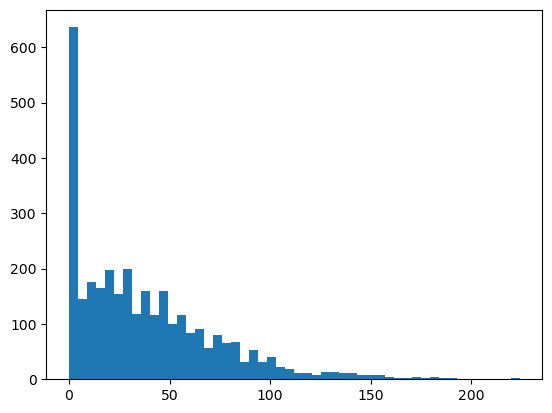

In [4]:
plt.hist(data['messages'],bins = 50)
plt.show()

We can see in all of the columns that the mean and median are fairly similar and that are no real extreme values, other then the messages column. I will remove the extreme values here so that the model doesn't train on extreme values. 

In [5]:
np.percentile(data['messages'], [95, 99])

array([106.  , 154.87])

I will remove the top 5 % so that our models train on correct data.

In [6]:
filtered_data = data[data['messages']<107]
filtered_data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3057.000000,3057.000000,3057.000000,3057.000000,3057.000000
mean,62.395813,433.655411,33.135754,16931.602617,0.279359
std,32.083452,226.754865,28.267877,7427.254409,0.448758
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.710000,8.000000,12371.770000,0.000000
50%,62.000000,430.160000,28.000000,16743.650000,0.000000
75%,82.000000,565.300000,52.000000,21090.670000,1.000000
max,244.000000,1632.060000,106.000000,48351.610000,1.000000


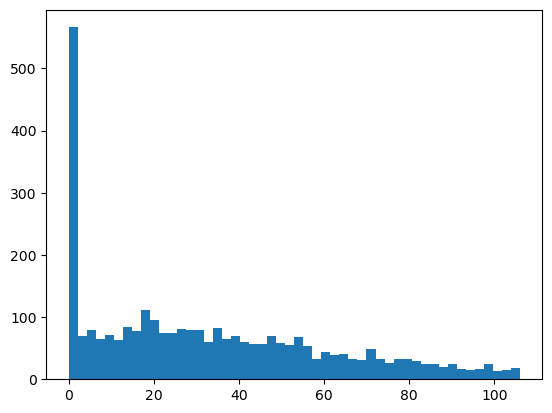

In [7]:
plt.hist(filtered_data['messages'],bins = 50)
plt.show()

Now I'll test if any of our predictors (or model features) are correlated, if they are, I'll remove one of them from the analysis. 

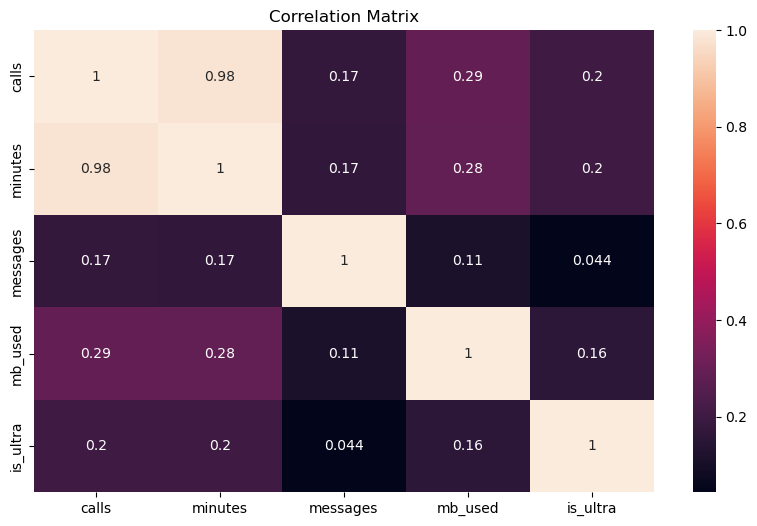

In [8]:
corr_mat = filtered_data.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr_mat,annot = True)
plt.title('Correlation Matrix')
plt.show()

minutes and calls are highly correlated. This makes a lot of sense since minutes is dependant on making a call, and any call you make takes minutes. Since I didn't get much details on what is the purpose of Ultra group vs. Smart, I'm can only guess that Ultra is a plan for heavy users. In this case number of total minutes means more than number of calls. 

In [9]:
filtered_data = filtered_data.drop(['calls'],axis = 1)
filtered_data

,minutes,messages,mb_used,is_ultra
0,311.90,83.0,19915.42,0
1,516.75,56.0,22696.96,0
2,467.66,86.0,21060.45,0
3,745.53,81.0,8437.39,1
4,418.74,1.0,14502.75,0
...,...,...,...,...
3209,910.98,20.0,35124.90,1
3210,190.36,0.0,3275.61,0
3211,634.44,70.0,13974.06,0
3212,462.32,90.0,31239.78,0


### Splitting the data
Since we are required to split into train, validation and test sets I will split them in a 3:1:1 ratio (respectivly)

In [10]:
train, valid = train_test_split(filtered_data, test_size = 0.4 , random_state = 12)
valid_set, test_set = train_test_split(valid, test_size = 0.5, random_state = 12)

In [11]:
train.shape

(1834, 4)

In [12]:
valid_set.shape

(611, 4)

In [13]:
test_set.shape

(612, 4)

In [14]:
len(train)/len(filtered_data)

0.5999345763820739

#### Splitting each set into features and target
Our target is the is_ultra column, the others are all features.

In [15]:
train_features = train.drop(['is_ultra'], axis = 1)
train_target = train['is_ultra']
display(train_features.head())
display(train_target.head())

,minutes,messages,mb_used
1962,419.13,38.0,26240.86
3015,285.25,34.0,11348.42
2254,402.45,30.0,23445.31
3180,165.05,0.0,9607.85
592,73.47,20.0,8602.19


1962    0
3015    0
2254    0
3180    0
592     0
Name: is_ultra, dtype: int64

In [16]:
valid_features = valid_set.drop(['is_ultra'],axis = 1)
valid_target = valid_set['is_ultra']
test_features = test_set.drop(['is_ultra'], axis = 1)
test_target = test_set['is_ultra']

### Training models
Now that we split the data, it's time to train our models. 
I will start with decision tree

In [17]:
model1 = DecisionTreeClassifier(random_state = 12345)
model1.fit(train_features, train_target)


DecisionTreeClassifier(random_state=12345)

In [18]:
#prediction using the validation set
model_pred = model1.predict(valid_features)

In [19]:
model1.score(valid_features, valid_target)

0.7086743044189853

This is a low score, since our cutout thershold is 0.75 accuracy. I will try to tune it a bit, if it still doesn't work out we will have different algorithems to try. 

In [20]:
from sklearn.tree import export_text
text_representation = export_text(model1)
print(text_representation)

|--- feature_2 <= 26262.68
|   |--- feature_0 <= 742.11
|   |   |--- feature_2 <= 10193.55
|   |   |   |--- feature_0 <= 629.35
|   |   |   |   |--- feature_2 <= 367.57
|   |   |   |   |   |--- feature_0 <= 73.15
|   |   |   |   |   |   |--- feature_1 <= 0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_1 >  0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_0 >  73.15
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_2 >  367.57
|   |   |   |   |   |--- feature_1 <= 56.50
|   |   |   |   |   |   |--- feature_0 <= 59.13
|   |   |   |   |   |   |   |--- feature_1 <= 14.00
|   |   |   |   |   |   |   |   |--- feature_1 <= 0.50
|   |   |   |   |   |   |   |   |   |--- feature_2 <= 1501.99
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- feature_2 >  1501.99
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- feature_1 >  0.50


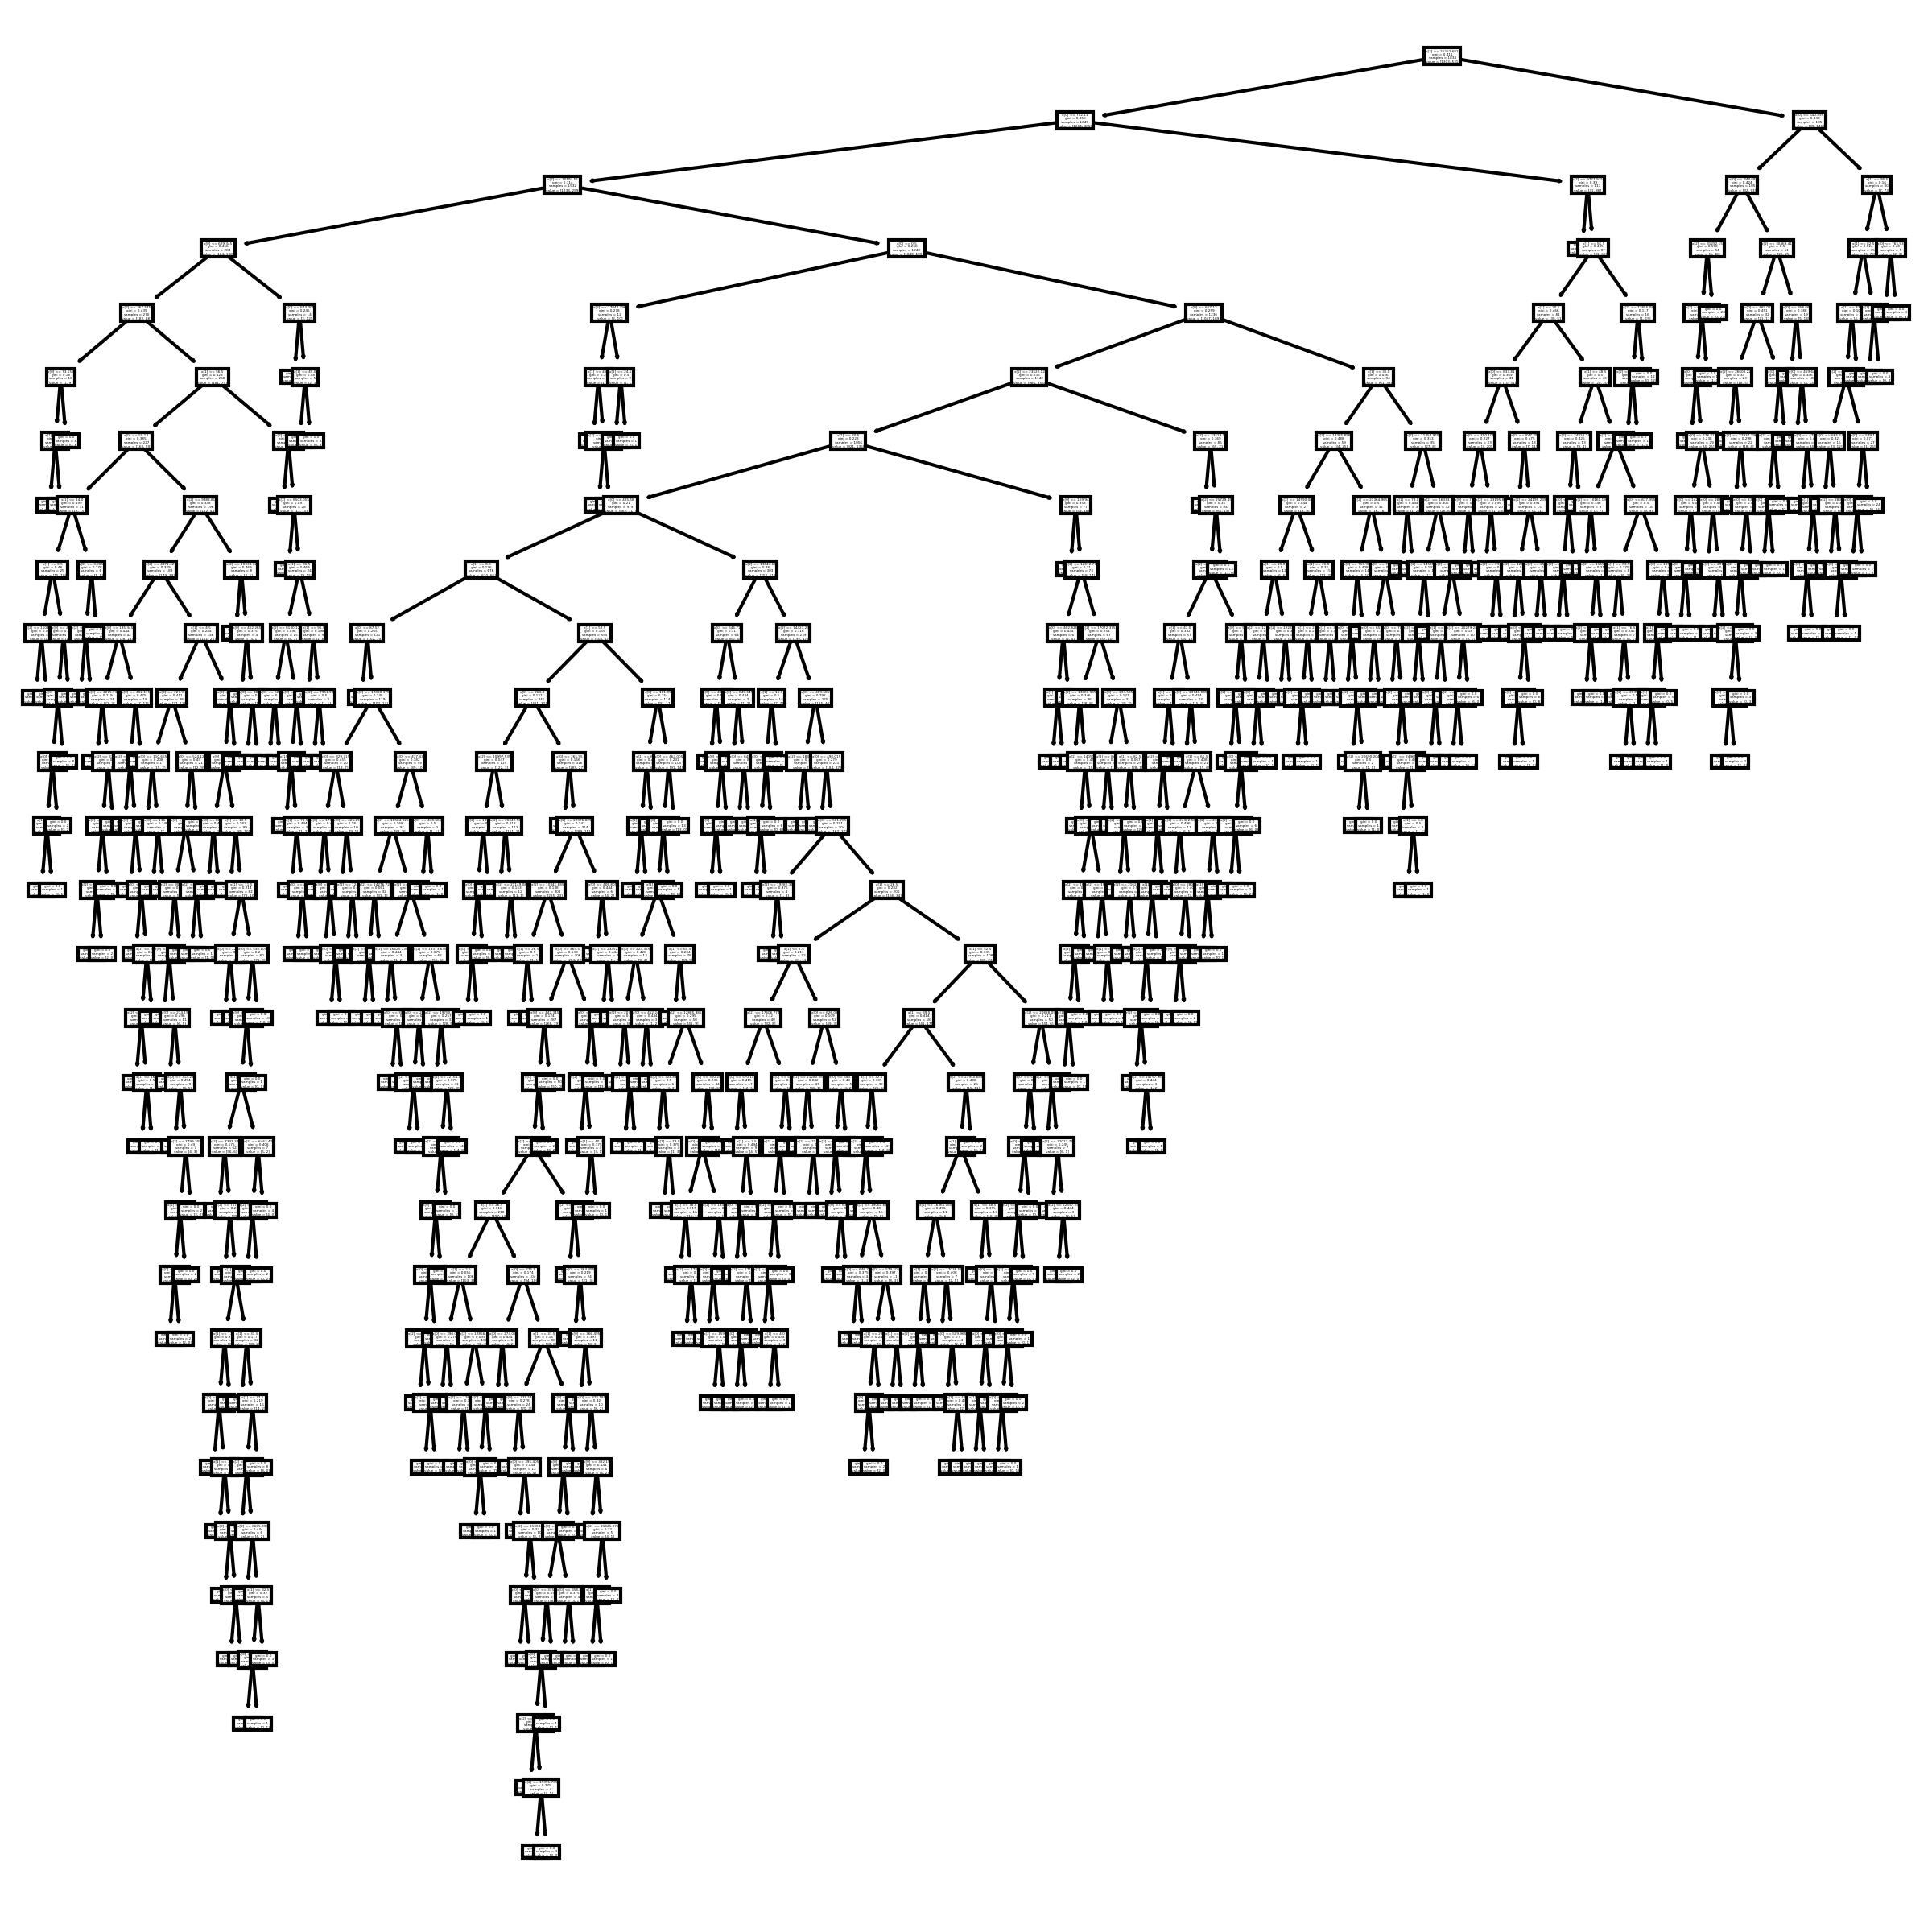

In [21]:
from sklearn.tree import plot_tree

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10,10), dpi = 300)

plot_tree(model1);

The depth of the model is huge, and the model is likely overfitted. I will try to see if it is possible to scale it down.

In [22]:
best_depth = 0
best_accuracy = 0

for depth in range(1,10):
    model = DecisionTreeClassifier(random_state = 12345, max_depth = depth)
    model.fit(train_features, train_target)
    model.predict(valid_features)
    accuracy = model.score(valid_features, valid_target)
    if accuracy > best_accuracy:
        best_depth = depth
        best_accuracy = accuracy
print('Highest score model has:',best_accuracy,'accuracy. Depth is:',best_depth)

Highest score model has: 0.7937806873977087 accuracy. Depth is: 8


This is higher then we got before, but maybe a different algorithm can offer better resoults. I will test it with the test set now. 

In [23]:
model1 = DecisionTreeClassifier(random_state = 12345, max_depth = 8)
model1.fit(train_features, train_target)
prediction_test = model1.predict(test_features)
tree_accuracy = accuracy_score(test_target, prediction_test)
print('The accuracy score for the test set is:',tree_accuracy)

The accuracy score for the test set is: 0.7810457516339869


Now I'll try Random Forest

In [24]:
# I will create a loop to find what number of trees give the most accuracy.
best_score = 0
best_est = 0
for n in range(1,50):
    model2 = RandomForestClassifier(random_state = 12345, n_estimators = n)
    model2.fit(train_features, train_target)
    score = model2.score(valid_features, valid_target)
    if score > best_score:
        best_est = n
        best_score = score
print('Best number of trees is:',best_est,'with accuracy:',best_score)

Best number of trees is: 8 with accuracy: 0.806873977086743


In [25]:
model2 = RandomForestClassifier(random_state = 12345, n_estimators = 8)
model2.fit(train_features, train_target)
prediction_test2 = model2.predict(test_features)
forest_accuracy = accuracy_score(test_target, prediction_test2)
print('The accuracy score for the test set is:',forest_accuracy)

The accuracy score for the test set is: 0.8055555555555556


The Random Forest algorithm gave a slightly more accurate model. I will try Logistic Regression now.

In [26]:
model3 = LogisticRegression(random_state = 12345, solver='liblinear')
model3.fit(train_features, train_target)
model3.score(valid_features, valid_target)
print('Logistic Regression training score is:',score)

Logistic Regression training score is: 0.8019639934533551


In [27]:
log_prediction = model3.predict(test_features)
log_accuracy = accuracy_score(test_target, log_prediction)
print('The model accuracy score is:',log_accuracy)


The model accuracy score is: 0.7532679738562091


The Logistic Regression model seems overfitted, and just barely passes the threshold we need. 

Random Forest seems to yeild the most accurate model for our task. Now to run a sanity check. 

### Sanity checking our model

Since this is a classification task I will use proportions of right positive predictions from the total positive predictions to test precision, and proportion of right positive predictions from total amount of positive outcomes to test for recall. 

In [28]:
cm_rf = confusion_matrix(test_target, prediction_test2)
cm_rf

array([[428,  32],
       [ 87,  65]])

In [29]:
TP = cm_rf[1, 1]
FP = cm_rf[0, 1]
FN = cm_rf[1, 0]
TN = cm_rf[0,0]

In [30]:
#checking for precision and recall:
precision = TP / (TP + FP)
recall = TP / (TP + FN)

print('Model precision is:',precision)
print('Model recall is:',recall)

Model precision is: 0.6701030927835051
Model recall is: 0.4276315789473684


Both values are pretty low. The precision of the model is less than 70%. In our case it means that 33% of customers that were classefied as ultras by the model are not really ultras. Recall is very low. Around 43%. This means that almost 60% of customers that should be classified as ultra are not. Prehaps in this stage we need to look back at our parameters and our data, and consider other variables that might be related to whether a person chose one of the new plans or not. It looks like the model is low quality because the given data is not the best way to predict our target.  

### Summary
The highest accuaracy score model was Random Forest (classifier)
However, the model is of pretty low quality. It is possible the features in our data are not good predictors of whether the customer chose Ultra or Smart plan, and we should consider adding other predictors, prehaps regarding the cost of the plan, first connections to the customer who already have the same plan, or even field of work. It seems the useage alone is not a good predictor for recommending a specific plan.  